In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

In [2]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q,conn)

In [3]:
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c) 

In [4]:
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

show_tables()

,name,type
0,Album,table
1,Artist,table
2,Customer,table
3,Employee,table
4,Genre,table
5,Invoice,table
6,InvoiceLine,table
7,MediaType,table
8,Playlist,table
9,PlaylistTrack,table


In [8]:
albums_to_purchase = '''
WITH 
    usa_tracks_sold AS
        (
         SELECT il.* FROM InvoiceLine il
         INNER JOIN Invoice i ON il.InvoiceId = i.InvoiceId
         INNER JOIN Customer c ON i.CustomerId = c.CustomerId
         WHERE c.Country = "USA" 
        )
SELECT 
    g.Name Genre, 
    COUNT(uts.InvoiceLineId) "Number of Tracks Sold", 
    CAST(COUNT(uts.InvoiceLineId) AS FLOAT)/(SELECT COUNT(*) FROM usa_tracks_sold) "Percentage of Tracks Sold"
FROM usa_tracks_sold uts
INNER JOIN Track t ON uts.TrackId = t.TrackId
INNER JOIN Genre g ON t.GenreId = g.GenreId
GROUP BY 1 
ORDER BY 2 DESC
LIMIT 10;
'''

run_query(albums_to_purchase)

,Genre,Number of Tracks Sold,Percentage of Tracks Sold
0,Rock,157,0.317814
1,Latin,91,0.184211
2,Metal,64,0.129555
3,Alternative & Punk,50,0.101215
4,Jazz,22,0.044534
5,Blues,15,0.030364
6,TV Shows,14,0.028340
7,R&B/Soul,12,0.024291
8,Comedy,8,0.016194
9,Classical,8,0.016194


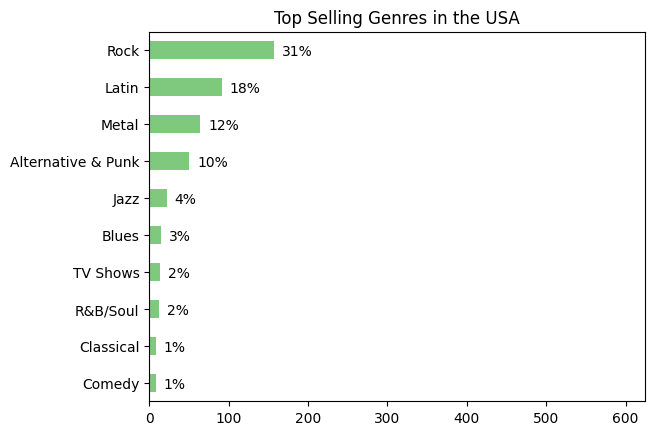

In [9]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index('Genre', drop=True, inplace=True)
genre_sales_usa.sort_values('Number of Tracks Sold', inplace=True)
genre_sales_usa['Number of Tracks Sold'].plot.barh(
        title="Top Selling Genres in the USA",
        xlim=(0, 625),
        colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "Number of Tracks Sold"]
    label = (genre_sales_usa.loc[label, "Percentage of Tracks Sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

In [21]:
employee_sales_performance = '''
WITH 
    customer_support_rep_sales AS
        (
         SELECT 
             i.CustomerId,
             c.SupportRepId,
             SUM(i.total) Sales_Total
         FROM Invoice i
         INNER JOIN Customer c ON c.CustomerId = i.CustomerId
         GROUP BY 2
        )
SELECT
    e.FirstName || " " || e.LastName "Employee Name",
    e.HireDate "Hire Date",
    SUM(csrs.Sales_total) "Amount of Sales (in $)"
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON csrs.SupportRepId = e.EmployeeId
GROUP BY 1;
'''

run_query(employee_sales_performance)

,Employee Name,Hire Date,Amount of Sales (in $)
0,Jane Peacock,2002-04-01 00:00:00,833.04
1,Margaret Park,2003-05-03 00:00:00,775.40
2,Steve Johnson,2003-10-17 00:00:00,720.16


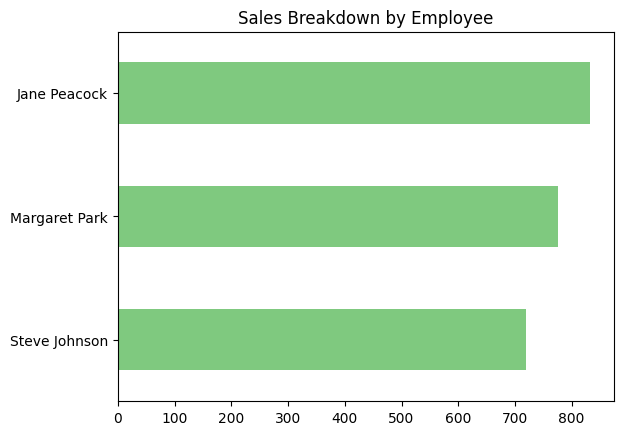

In [23]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("Employee Name", drop=True, inplace=True)
employee_sales.sort_values("Amount of Sales (in $)", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

In [24]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.CustomerId,
       il.*
     FROM InvoiceLine il
     INNER JOIN invoice i ON i.InvoiceId = il.InvoiceId
     INNER JOIN customer c ON c.CustomerId = i.CustomerId
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct CustomerId) customers,
        SUM(UnitPrice) total_sales,
        SUM(UnitPrice) / count(distinct CustomerId) customer_lifetime_value,
        SUM(UnitPrice) / count(distinct InvoiceId) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)


,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,523.06,5.747912,40.235385
1,Canada,8,303.96,5.427857,37.995000
2,France,5,195.10,5.574286,39.020000
3,Brazil,5,190.10,5.431429,38.020000
4,Germany,4,156.48,5.588571,39.120000
5,United Kingdom,3,112.86,5.374286,37.620000
6,Czech Republic,2,90.24,6.445714,45.120000
7,Portugal,2,77.24,5.517143,38.620000
8,India,2,75.26,5.789231,37.630000
9,Other,15,604.30,5.755238,40.286667


,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,523.06,5.747912,40.235385
1,Canada,8,303.96,5.427857,37.995000
2,France,5,195.10,5.574286,39.020000
3,Brazil,5,190.10,5.431429,38.020000
4,Germany,4,156.48,5.588571,39.120000


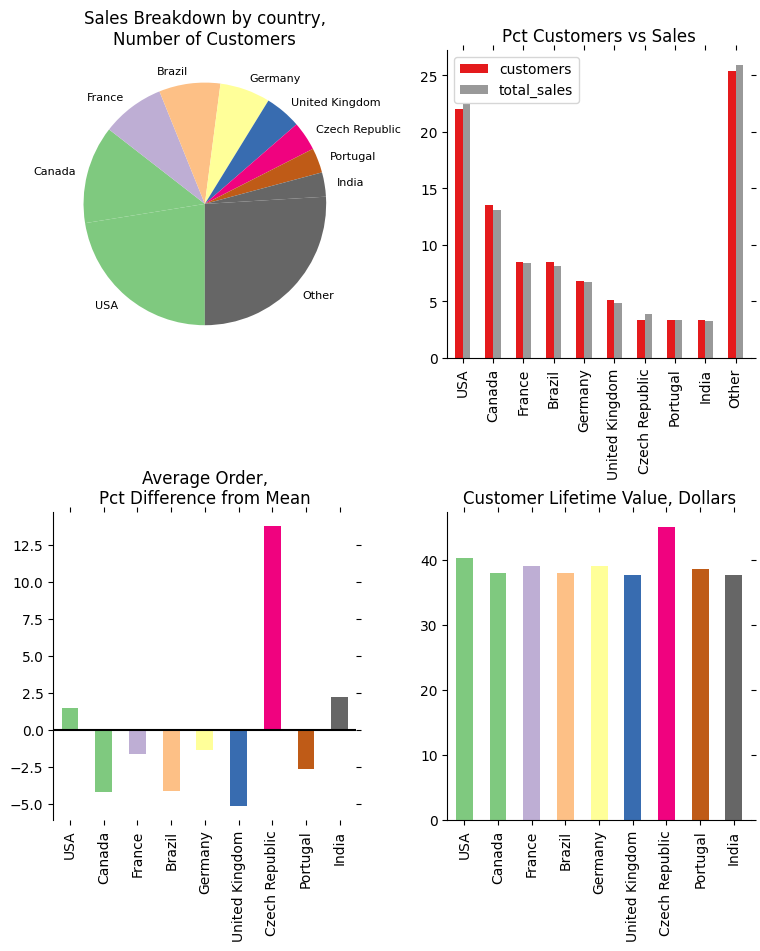

In [45]:
country_metrics = run_query(sales_by_country)
country_metrics.head() 

country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)



# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)


# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()
